<a href="https://colab.research.google.com/github/auras726/IA/blob/main/Tema2_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import biblioteci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")

In [ ]:
# 2. Încarcă datasetul (varianta Kaggle)
# Poți urca fișierul CSV manual în Colab: Files → Upload
# sau îl poți pune în Google Drive și modifica calea.

df = pd.read_csv("/content/WineQT.csv")   # ← modifică aici numele dacă e diferit
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [ ]:
# 3. Explorare rapidă
print(df.shape)
print(df.info())
print(df.describe())

# Elimină orice coloană inutilă (în unele versiuni există un ID)
if "Id" in df.columns:
    df = df.drop("Id", axis=1)

NameError: name 'df' is not defined

In [ ]:
# 4. Separă features și target
X = df.drop("quality", axis=1)
y = df["quality"]

In [ ]:
# 5. Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# 6. Definește modelele ce vor fi comparate
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1, max_iter=10000)
}

results = {}

# Pipeline cu StandardScaler + model
for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    results[name] = [rmse, mae, r2]
    print(f"{name}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")

Linear Regression: RMSE=0.616, MAE=0.477, R2=0.317
Ridge Regression: RMSE=0.616, MAE=0.477, R2=0.317
Lasso Regression: RMSE=0.618, MAE=0.500, R2=0.313


In [ ]:
# 7. Tabel cu rezultate
results_df = pd.DataFrame(results, index=["RMSE", "MAE", "R2"]).T
print("\n=== Rezultate comparate ===")
print(results_df)


=== Rezultate comparate ===
                       RMSE       MAE        R2
Linear Regression  0.616468  0.477340  0.317069
Ridge Regression   0.616345  0.477311  0.317341
Lasso Regression   0.618157  0.499503  0.313321


In [ ]:
# 8. Tuning alpha pentru Ridge și Lasso
alphas = np.logspace(-3, 2, 20)
ridge_scores = []
lasso_scores = []

for a in alphas:
    ridge = Pipeline([("scaler", StandardScaler()),
                      ("model", Ridge(alpha=a))])
    lasso = Pipeline([("scaler", StandardScaler()),
                      ("model", Lasso(alpha=a, max_iter=10000))])

    # Cross-validation 5-fold
    ridge_rmse = -cross_val_score(ridge, X, y,
                                  scoring="neg_mean_squared_error",
                                  cv=5).mean()
    lasso_rmse = -cross_val_score(lasso, X, y,
                                  scoring="neg_mean_squared_error",
                                  cv=5).mean()

    ridge_scores.append(np.sqrt(ridge_rmse))
    lasso_scores.append(np.sqrt(lasso_rmse))

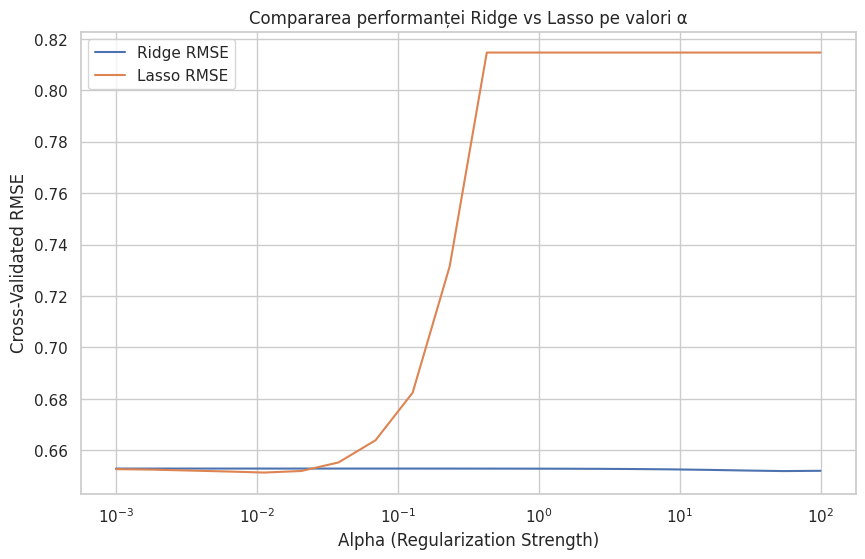

In [ ]:
# 9. Plot tuning α
plt.figure(figsize=(10,6))
plt.plot(alphas, ridge_scores, label="Ridge RMSE")
plt.plot(alphas, lasso_scores, label="Lasso RMSE")
plt.xscale("log")
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Cross-Validated RMSE")
plt.title("Compararea performanței Ridge vs Lasso pe valori α")
plt.legend()
plt.show()

In [ ]:
# 10. Analyza coeficienților pentru cel mai bun model
best_alpha_ridge = alphas[np.argmin(ridge_scores)]
best_alpha_lasso = alphas[np.argmin(lasso_scores)]

print("Best Ridge alpha:", best_alpha_ridge)
print("Best Lasso alpha:", best_alpha_lasso)

best_ridge = Ridge(alpha=best_alpha_ridge)
best_lasso = Lasso(alpha=best_alpha_lasso, max_iter=10000)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

best_ridge.fit(X_scaled, y_train)
best_lasso.fit(X_scaled, y_train)

coef_df = pd.DataFrame({
    "feature": X.columns,
    "Ridge_coef": best_ridge.coef_,
    "Lasso_coef": best_lasso.coef_
})

print("\n=== Coeficienți ridge vs lasso ===")
print(coef_df)

Best Ridge alpha: 54.555947811685144
Best Lasso alpha: 0.011288378916846888

=== Coeficienți ridge vs lasso ===
                 feature  Ridge_coef  Lasso_coef
0          fixed acidity    0.075585    0.014589
1       volatile acidity   -0.218449   -0.221180
2            citric acid   -0.032434   -0.006044
3         residual sugar    0.006900   -0.000000
4              chlorides   -0.086810   -0.080686
5    free sulfur dioxide    0.017313    0.000000
6   total sulfur dioxide   -0.074527   -0.060712
7                density   -0.067988   -0.012478
8                     pH   -0.029492   -0.034683
9              sulphates    0.154437    0.138507
10               alcohol    0.263398    0.293722


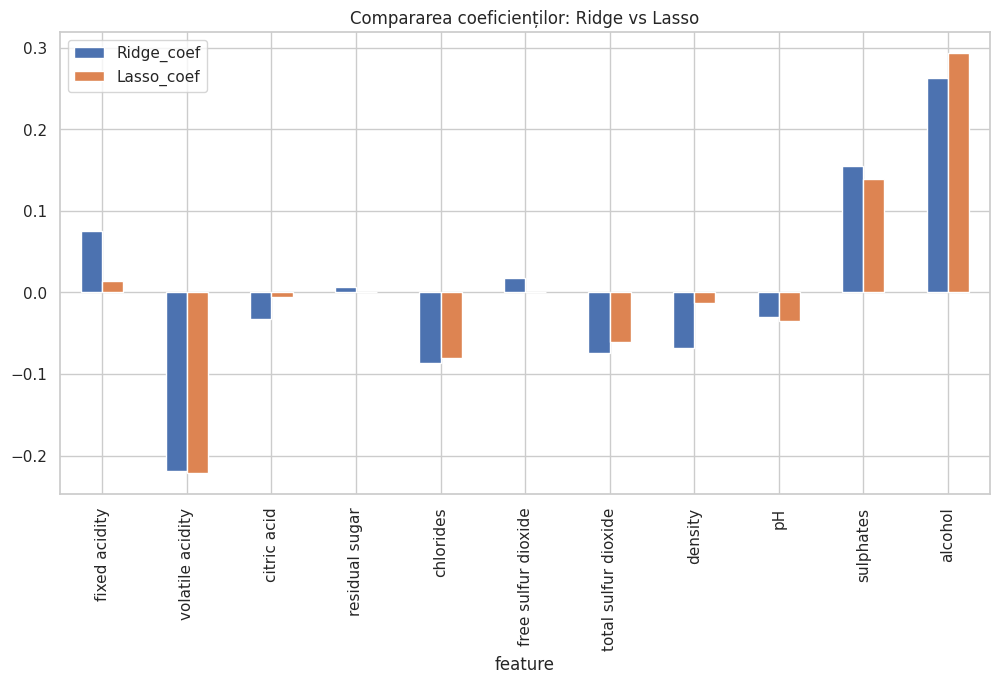

In [ ]:
# 11. Plot coeficienți side-by-side
coef_df.set_index("feature").plot(kind="bar", figsize=(12,6))
plt.title("Compararea coeficienților: Ridge vs Lasso")
plt.show()